In [29]:
import polars as pl
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../')

In [2]:
p = Path().resolve().parents[0] / 'data' / 'raw_bin_samples' / 'clean.arrow'
lf = pl.scan_ipc(p)

In [3]:
df = lf.collect()

In [4]:
df

symbol,timestamp,price,trade
cat,datetime[μs],f64,i32
"""ADSK""",2019-01-02 09:30:00,125.205,-287
"""ADSK""",2019-01-02 09:30:10,124.61,20
"""ADSK""",2019-01-02 09:30:20,124.61,0
"""ADSK""",2019-01-02 09:30:30,125.155,200
"""ADSK""",2019-01-02 09:30:40,125.705,-385
…,…,…,…
"""ADS""",2019-12-27 15:59:20,110.915,0
"""ADS""",2019-12-27 15:59:30,110.95,0
"""ADS""",2019-12-27 15:59:40,110.92,0


In [5]:
from base.impactpy.model.subroutines import *
lf = df.lazy()

In [6]:
df = enhance_data(df, 30)

In [7]:
df

symbol,timestamp,price,trade,vola,adv
cat,datetime[μs],f64,i32,f64,f64
"""ADSK""",2019-01-02 09:30:00,125.205,-287,null,null
"""ADSK""",2019-01-02 09:30:10,124.61,20,null,null
"""ADSK""",2019-01-02 09:30:20,124.61,0,null,null
"""ADSK""",2019-01-02 09:30:30,125.155,200,null,null
"""ADSK""",2019-01-02 09:30:40,125.705,-385,null,null
…,…,…,…,…,…
"""ADS""",2019-12-27 15:59:20,110.915,0,0.02861,81498.9
"""ADS""",2019-12-27 15:59:30,110.95,0,0.02861,81498.9
"""ADS""",2019-12-27 15:59:40,110.92,0,0.02861,81498.9


In [35]:
half_life = 300
bin_duration = 10
beta = np.log(2) / half_life
decay = np.exp(-beta * bin_duration)

In [36]:
impact = (df.lazy()
	.with_columns(pl.col('trade').mul('vola').truediv('adv'))
	
	# EWM = ax_n-1 + (1-a)x_n, but we want ax_n-1 + x_n to approximate
	# exponential decay of the impact state. So divide by 1-a first.
	.with_columns(pl.lit(1 - decay).alias('norm'))
	# Don't divide first impact state by 1-a.
	.with_columns(pl.col('norm').shift().over(['symbol', pl.col('timestamp').dt.date()]).fill_null(1))
	.with_columns(pl.col('trade').truediv('norm'))
	.drop('norm')
	
	.with_columns(pl.col('trade').ewm_mean(
		alpha=(1 - decay), adjust=False, ignore_nulls=True
	).over([pl.col('symbol'), pl.col('timestamp').dt.date()]))
	.with_columns(pl.lit(1).alias('push'))
	# # .join(push.lazy(), on='symbol', how='left')
	.with_columns(pl.col('trade').mul('push').alias('impact'))
).collect()

In [47]:
impact2 = impact.with_columns(pl.col('price').pct_change().alias('return')).drop_nulls().tail(1_000_000)

In [51]:
impact

symbol,timestamp,price,trade,vola,adv,push,impact,return
cat,datetime[μs],f64,f64,f64,f64,i32,f64,f64
"""ADSK""",2019-02-01 09:30:00,147.67,0.0,0.034882,250607.285714,1,0.0,0.002648
"""ADSK""",2019-02-01 09:30:10,147.66,0.0,0.034882,250607.285714,1,0.0,-0.000068
"""ADSK""",2019-02-01 09:30:20,147.66,0.0,0.034882,250607.285714,1,0.0,0.0
"""ADSK""",2019-02-01 09:30:30,147.66,0.0,0.034882,250607.285714,1,0.0,0.0
"""ADSK""",2019-02-01 09:30:40,147.665,0.0,0.034882,250607.285714,1,0.0,0.000034
…,…,…,…,…,…,…,…,…
"""ADS""",2019-12-27 15:59:20,110.915,-0.00017,0.02861,81498.9,1,-0.00017,-0.000045
"""ADS""",2019-12-27 15:59:30,110.95,-0.000166,0.02861,81498.9,1,-0.000166,0.000316
"""ADS""",2019-12-27 15:59:40,110.92,-0.000162,0.02861,81498.9,1,-0.000162,-0.00027


In [52]:
from datetime import time
impact.filter(
	pl.col('timestamp').dt.time().ge(time(10)) & pl.col('timestamp').dt.time().le(time(16))
).select(pl.corr('impact', 'return'))

impact
f64
0.080245


In [45]:
x = impact.tail(100_000).select('impact')
y = impact.tail(100_000).select('return')

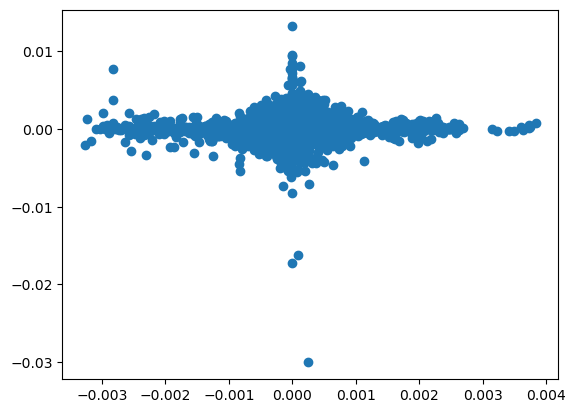

In [46]:
plt.scatter(x, y)

In [62]:
xx = pl.DataFrame({
	'a': [1, 1, 1, 2, 2, 2, 3, 3, 3],
	'b': [1, 2, 3] * 3,
	'c': [1] * 9,
	'd': list(range(9))
})
xx.pivot('d', 'c', ['a', 'b'])

C:\Users\lachl\AppData\Local\Temp\ipykernel_14308\2651680726.py:7: DeprecationWarning: The order of the parameters of `pivot` will change in the next breaking release. The order will become `index, columns, values` with `values` as an optional parameter. Use keyword arguments to silence this warning.
  xx.pivot('d', 'c', ['a', 'b'])


c,"{1,1}","{1,2}","{1,3}","{2,1}","{2,2}","{2,3}","{3,1}","{3,2}","{3,3}"
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,0,1,2,3,4,5,6,7,8


In [69]:
from functools import reduce

l = [
	(1, 2),
	(3, 4),
	(5, 6),
]

reduce(lambda a, *args: a + args[0][0], l, 0)

9